# Multiple images Instruction Generation
This notebook shows how to generate instruction tuning data from multiple images annotations. We include 14 different types of templates that covers `object`, `attribute`, `depth`, `object + depth`, `segmentation`, and `relation` QAs. We show the step-by-step guide of how we generate those questions by our generator.

In [47]:
from PIL import Image
from provision.base import *
from provision.generators.multi_image.aggregate import *
from provision.generators.multi_image.compare import *
from provision.generators.multi_image.select import *


ANNOTATION_DIR = "notebooks/baseball_sample_annotations"
IMAGE_DIR = f"{ANNOTATION_DIR}/images"
N_WORKERS = 1

We generate QA pairs based on this two images. The above one describing a batter swinging a bat towards a baseball, while the below one showing a batter swinging a bat and a catcher wating for catch the baseball behind the hitter.

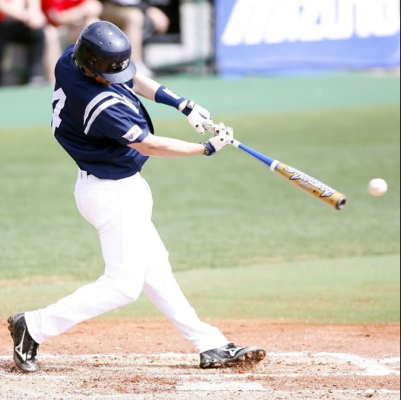

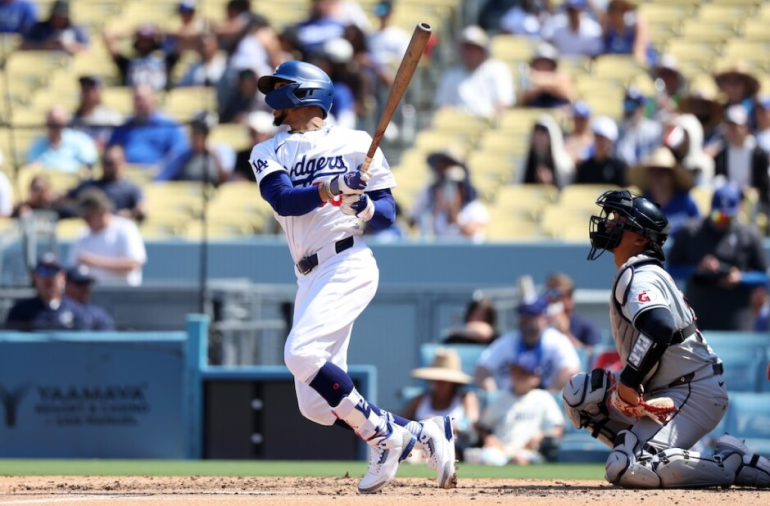

In [ ]:
sample_image1 = Image.open(f"{IMAGE_DIR}/baseball_1.png")
sample_image1.show()

sample_image2 = Image.open(f"{IMAGE_DIR}/baseball_2.png")
sample_image2.show()

## Dataset & Generator initialization
We have summarized all types of annotations of the above two images in `baseball_sample_annotations`. Now we read the annotations by `JointDataset` and initialize our generator.

In [49]:
sample_dataset = JointDataset(
	[f"{ANNOTATION_DIR}/object-detection-annotations.json",
	 f"{ANNOTATION_DIR}/segmentation-annotations.json",
	 f"{ANNOTATION_DIR}/depth-estimation-annotations.json",
	 f"{ANNOTATION_DIR}/image-attributes-annotations.json",
	 f"{ANNOTATION_DIR}/relation-annotations-parsed.json"],
	seg_dir_path=f"{ANNOTATION_DIR}/seg_masks",
	depth_dir_path=f"{ANNOTATION_DIR}/depth_masks"
)

generator_list = (
	MultiSelectGeneratorList +
	MultiAggregateGeneratorList +
	MultiCompareGeneratorList
)

gen = JointGenerator(
	dataset=sample_dataset,
	generators=generator_list,
	template_mode='qa',
	return_templated=False,
	n_data=2,
	n_sample=1
)


The generator will generate question-answer pairs as our instruction-tuning data according to annotations. The generated questions will then fill into our pre-defined templates to reduce the model's prompt sensitivity and improve the training robustness.

In [50]:
qas = gen.generate(n_workers=N_WORKERS)

metadata_count = {}
for i in qas:
    for k, vs in i['metadata'].items():
        if k not in metadata_count:
            metadata_count[k] = {}
        for v in vs:
            if v not in metadata_count[k]:
                metadata_count[k][v] = 0
            metadata_count[k][v] += 1

print("Number of QAs: ", len(qas))

instructions = gen.multi_image_template(qas, multiple_choice_ratio=0.0)
mc_instructions = gen.multi_image_template(qas, multiple_choice_ratio=1.0)

generating: 100%|██████████| 14/14 [00:00<00:00, 373.12it/s]


Number of QAs:  14


100%|██████████| 14/14 [00:00<00:00, 3773.31it/s]


Some examples of our generated instruction-tuning data:

In [51]:
import numpy as np


for i in np.random.choice(len(instructions), 5, replace=False):
    print("Example ", i + 1)
    print(instructions[i]['conversations'][0]['from'], ": ", instructions[i]['conversations'][0]['value'])
    print(instructions[i]['conversations'][1]['from'], ": ", instructions[i]['conversations'][1]['value'])
    print()

Example  6
human :  Determine which image doesn't have golden bat?
<image> <image>
gpt :  Image 0

Example  5
human :  <image> <image>
Identify which image shows white bat?
gpt :  Image 0

Example  14
human :  <image> <image>
Can you tell the difference of attributes of bat across these images?
gpt :  bat is blue, golden, wooden, and white in Image 0, brown and wooden in Image 1.

Example  12
human :  <image> <image>
Tell me what is the number of wooden bat that you see across these images?
gpt :  two

Example  1
human :  <image> <image>
Can you tell in which image batter is swinging bat?
gpt :  Image 0

